In [1]:
import pandas as pd 
import numpy as np 
from textblob import TextBlob
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import json, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim

from sentiment_analysis_spanish import sentiment_analysis
import nltk
import pyLDAvis.gensim_models

import random
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#df = pd.read_excel('Resultados Touchpoint APP Personas del 1abr al 24 May.xlsx')
df = pd.read_excel('Touchpoint APP Personas 1 May al 31Jul.xlsx')
df.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
0,Fecha de inicio,Fecha de finalización,Tipo de respuesta,Dirección IP,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714000,R_3ISGyOV01BzngPO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
len(df)

44489

In [4]:
df = df.drop([0], axis=0)
df.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q15 - Topic Sentiment Label,Q15 - Topic Sentiment Score,Q15 - Topics,Q20 - Parent Topics,Q20 - Sentiment Polarity,Q20 - Sentiment Score,Q20 - Sentiment,Q20 - Topic Sentiment Label,Q20 - Topic Sentiment Score,Q20 - Topics
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714000,R_3ISGyOV01BzngPO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-30 00:08:19,2021-04-30 00:10:59,IP Address,191.156.153.227,38,160,False,2021-05-01 00:11:00.156000,R_22t2EpjmNZEoqFT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.Q2_NPS_GROUP.value_counts()

Promotor     24178
Detractor     8721
Pasivo        7740
Name: Q2_NPS_GROUP, dtype: int64

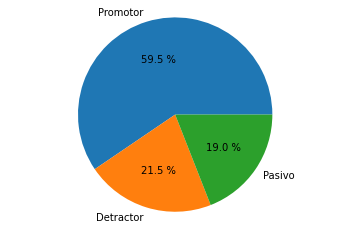

In [6]:
A = df.Q2_NPS_GROUP.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

####  Funciones para Limpieza de texto

In [7]:
def limpiar_texto(texto):
    """
    Función para realizar la limpieza de un texto dado.
    """
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminamos comas y /
    texto = re.sub(r',', ' ', str(texto))
    texto = re.sub(r'/', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

In [8]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("spanish"))
def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CristhianJohnatanIzq\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
stemmer = SnowballStemmer("spanish")
def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

In [10]:
def Limpiar_Caracter(texto):
    if len(texto) == 1 or texto == ',':
        texto = ''
    else:
        texto = texto
    return texto

###  Seleccion de Preguntas

In [11]:
Qs=['Q4','Q10','Q12','Q15','Q18','Q20']

###  Analisis de sentimientos

In [12]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()

In [13]:
dfSent=df.fillna('')

In [14]:
tokenizer = ToktokTokenizer() 
Lista_general=[]
for column in Qs:
    dfSent["Tokens_"+column]=dfSent[column].apply(limpiar_texto)
    dfSent["Sent_"+column] =  np.where(dfSent["Tokens_"+column]!='', dfSent[column].apply(sentiment.sentiment)*2-1,'')
    
dfSent.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q10,Sent_Q10,Tokens_Q12,Sent_Q12,Tokens_Q15,Sent_Q15,Tokens_Q18,Sent_Q18,Tokens_Q20,Sent_Q20
1,2021-05-01 00:01:09,2021-05-01 00:02:59,IP Address,181.78.16.235,100,110,True,2021-05-01 00:02:59.714,R_3ISGyOV01BzngPO,,...,,,,,,,,,,
2,2021-04-30 00:08:19,2021-04-30 00:10:59,IP Address,191.156.153.227,38,160,False,2021-05-01 00:11:00.156,R_22t2EpjmNZEoqFT,,...,,,,,,,,,,


##### Fin Analisis de Sentimiento

####  Preprocesamiento

In [15]:
tokenizer = ToktokTokenizer() 
Lista_general=[]
dfc = dfSent[dfSent['Q2_NPS_GROUP']!='Promotor']
for column in Qs:    
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(tokenizer.tokenize)
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(filtrar_stopword_digitos)
    dfc["Tokens_"+column] = dfc["Tokens_"+column].apply(stem_palabras)
    #solo ciertas Qs son agregadas
    if column in ('Q4','Q10','Q12','Q15','Q18','Q20') :
        listAux = dfc["Tokens_"+column].tolist()
        listAux = [x for x in listAux if x!= []]
        #print("Qs")
        print(column, len(listAux))
        Lista_general = Lista_general+listAux

Q4 3098
Q10 764
Q12 2055
Q15 5434
Q18 4412
Q20 1366


###  Modelo de Tópicos

In [16]:
### Funciones para modelo de tópicos
def make_bigrams(texts,bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts,bigram_mod,trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def impresionTopicos(mod,nPalabras,nTopicos):
    topicos = mod.print_topics(num_words=nPalabras, num_topics=nTopicos)
    for topico in topicos:
        print(topico)    
        
def impresionTopicosLimp(mod,nPalabras,nTopicos):
    #Impresion limpia de Tópicos
    topicos = mod.print_topics(num_words=nPalabras, num_topics=nTopicos)
    i=0
    for topico in topicos:
        i=i+1
        textoAux = re.sub(r'\W', ' ', str(topico))
        textoAux = re.sub(r'\s+[a-zA-Z]\s+', ' ', textoAux)
        textoAux = re.sub(r'[0-9]', ' ', textoAux)
        textoAux = re.sub(r'\s+', ' ', textoAux, flags=re.I)
        print(str(i),textoAux)

In [17]:
bigram = gensim.models.Phrases(Lista_general, min_count=5, threshold=10) 
trigram = gensim.models.Phrases(bigram[Lista_general], threshold=10)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_words_bigrams = make_bigrams(Lista_general,bigram_mod)

diccionario = Dictionary(data_words_bigrams)
print(f'Número de tokens: {len(diccionario)}')

diccionario.filter_extremes(no_below=2, no_above = 0.9)
print(f'Número de tokens: {len(diccionario)}')

corpus = [diccionario.doc2bow(noticia) for noticia in data_words_bigrams]

Número de tokens: 4753
Número de tokens: 2272


In [18]:
numeroTopicos=5

In [19]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=numeroTopicos, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [20]:
impresionTopicos(lda,5,20)

(0, '0.065*"dat" + 0.042*"funcion" + 0.035*"bien" + 0.022*"sirv" + 0.021*"gust"')
(1, '0.096*"servici" + 0.062*"buen" + 0.050*"internet" + 0.042*"mal" + 0.039*"señal"')
(2, '0.064*"clar" + 0.058*"plan" + 0.035*"necesit" + 0.034*"inform" + 0.032*"opcion"')
(3, '0.082*"app" + 0.081*"pag" + 0.059*"factur" + 0.046*"hac" + 0.039*"aplic"')
(4, '0.061*"pued" + 0.055*"dej" + 0.044*"ingres" + 0.043*"ver" + 0.037*"pud"')


In [21]:
impresionTopicosLimp(lda,15,20)
#Guardar tabla de palabras

1  dat funcion bien sirv gust nunc cancel cobr asesor moment tiemp pas lleg red usuari 
2  servici buen internet mal señal llam lent mejor graci demor excelent pesim client rap vec 
3  clar plan necesit inform opcion line cambi facil encuentr solucion telefon encontr benefici sab ten 
4  app pag factur hac aplic recarg consult si compr sald realiz quier activ sal compr_paquet 
5  pued dej ingres ver pud registr equip pod cuent clar_hog numer celul permit dic aparec 


In [22]:
lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, diccionario, sort_topics=False)
pyLDAvis.display(lda_display)

In [23]:
pyLDAvis.save_html(lda_display, 'lda_General_4_V3.html')

####  fin simplificación

###  Clasificación de los textos en tópicos

In [24]:
dfc2 = dfc.fillna('')

In [25]:
len(dfc2)

20310

In [26]:
for column in Qs:    
    dfc2["Tokens_"+column+"_T"] = dfc2["Tokens_"+column]
    dfc2["Tokens_"+column] =  dfc2[column].apply(limpiar_texto)
    dfc2["Tokens_"+column] =  dfc2[column].apply(Limpiar_Caracter)

In [27]:
columnasDefTopico=['Q12','Q15','Q18']
dfc2['Opinion'] = ''
for i in dfc2.index:
    for column in columnasDefTopico: 
        dfc2.loc[i,'Opinion']=dfc2.loc[i,'Opinion']+str(dfc2.loc[i,"Tokens_"+column])+" "
dfc2.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q18,Tokens_Q20,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion
4,2021-05-01 00:14:21,2021-05-01 00:15:37,IP Address,181.53.12.201,100,76,True,2021-05-01 00:15:38.223,R_udHanua3i8beZtT,,...,,,,[ningun],[],[],[],[],[],
9,2021-05-01 00:56:56,2021-05-01 00:58:36,IP Address,191.156.52.30,100,100,True,2021-05-01 00:58:37.141,R_XjMcEuP3zshnpF7,,...,,Me parece bien,-0.8938357315867129,"[qued, sald, carg, app, pod, recarg, vez]",[],[],[],[],"[parec, bien]",


In [28]:
dfc2['Opinion'] = dfc2['Opinion'].apply(tokenizer.tokenize)
dfc2['Opinion'] = dfc2['Opinion'].apply(filtrar_stopword_digitos)
dfc2['Opinion'] = dfc2['Opinion'].apply(stem_palabras)
dfc2['Opinion'] 

4                                                       []
9                                                       []
10                                            [mal, señal]
11       [me, cambi, x, mes, oper, regres, nuev, sub, m...
13       [se, demor, carg, despues, dic, sient, trabaj,...
                               ...                        
44482    [muy, lent, siempr, mantien, caid, muy, lent, ...
44483                                                   []
44484                                                   []
44485                                                   []
44488                                                   []
Name: Opinion, Length: 20310, dtype: object

In [29]:
for i in dfc2.index:    
    if dfc2.loc[i,'Opinion']==[]:
        dfc2.drop([i], inplace=True)
dfc2.head(2)

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q18,Tokens_Q20,Sent_Q20,Tokens_Q4_T,Tokens_Q10_T,Tokens_Q12_T,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173,R_x5YL4kva6EbeuWJ,,...,,,,[],[],[],"[mal, señal]",[],[],"[mal, señal]"
11,2021-05-01 01:15:49,2021-05-01 01:21:26,IP Address,186.29.191.43,100,336,True,2021-05-01 01:21:26.392,R_3ltBuR7i97QbFAM,,...,,,,"[bastant, tiemp, usted, sub, plan, line]",[],[],"[cambi, mes, oper, regres, nuev, sub, mil, pes...",[],[],"[me, cambi, x, mes, oper, regres, nuev, sub, m..."


In [30]:
dfc2['Tópico'] = ""
sumaTopicos = [0]*(numeroTopicos+1)
for i in dfc2.index:
    bow_comentario = diccionario.doc2bow(dfc2.loc[i,'Opinion'])
    distribucion_noticia = lda[bow_comentario]
    dist_contrib = [topico[1] for topico in lda[bow_comentario]]
    dfc2.loc[i,'Tópico']=dist_contrib.index(max(dist_contrib))+1
    
    # sumar pertenencias a los tópicos
    for idx, val in enumerate(dist_contrib):
        sumaTopicos[idx+1]=sumaTopicos[idx+1]+dist_contrib[idx]    

In [31]:
dfc2.Tópico.value_counts()

5    2203
4    1747
3    1029
2     827
1     657
Name: Tópico, dtype: int64

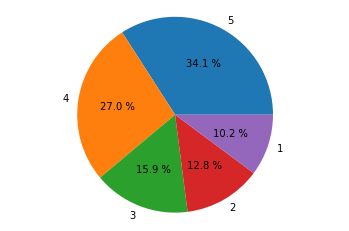

In [32]:
A = dfc2.Tópico.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

#####  Validación asignación de Tópicos

In [33]:
for index,score in sorted(lda[diccionario.doc2bow(dfc2.loc[10,'Opinion'])], key=lambda tup: -1*tup[1]):
    print("Score:{}\t Topic:{}".format(score,lda.print_topic(index,5)))

Score:0.34411078691482544	 Topic:0.096*"servici" + 0.062*"buen" + 0.050*"internet" + 0.042*"mal" + 0.039*"señal"
Score:0.19607801735401154	 Topic:0.061*"pued" + 0.055*"dej" + 0.044*"ingres" + 0.043*"ver" + 0.037*"pud"
Score:0.18521727621555328	 Topic:0.082*"app" + 0.081*"pag" + 0.059*"factur" + 0.046*"hac" + 0.039*"aplic"
Score:0.14534692466259003	 Topic:0.064*"clar" + 0.058*"plan" + 0.035*"necesit" + 0.034*"inform" + 0.032*"opcion"
Score:0.12924699485301971	 Topic:0.065*"dat" + 0.042*"funcion" + 0.035*"bien" + 0.022*"sirv" + 0.021*"gust"


In [34]:
bow_comentario = diccionario.doc2bow(dfc2.loc[10,'Opinion'])
distribucion_noticia = lda[bow_comentario]
dist_contrib = [topico[1] for topico in lda[bow_comentario]]
dist_contrib

[0.129247, 0.3441108, 0.14534692, 0.18521728, 0.19607802]

####  fin validacion

###  zoom al topico_4  número 3

In [35]:
numeroTopicos=4
topicoZoom=4

In [36]:
## Quitar pag pactur
dfc2Zoom=dfc2.copy()
dfc2Zoom['contienePagFact']=dfc2Zoom['Opinion'].apply(lambda x: 1 if 'pag' in x else 0)
dfc2Zoom=dfc2Zoom[dfc2Zoom['contienePagFact']==0]
dfc2Zoom=dfc2Zoom[dfc2Zoom['Tópico']==topicoZoom]

In [37]:
# Repite el proceso de topicos

In [38]:
Lista_generalZoom=[]
for column in Qs:   
    if column in ('Q4','Q10','Q12','Q15','Q18','Q20') :
        listAux = dfc2Zoom["Tokens_"+column+"_T"].tolist()
        listAux = [x for x in listAux if x!= []]
        Lista_generalZoom = Lista_generalZoom+listAux

In [39]:
bigramZoom = gensim.models.Phrases(Lista_generalZoom, min_count=5, threshold=10) 
trigramZoom = gensim.models.Phrases(bigramZoom[Lista_generalZoom], threshold=10)
bigram_modZoom = gensim.models.phrases.Phraser(bigramZoom)
trigram_modZoom = gensim.models.phrases.Phraser(trigramZoom)
data_words_bigramsZoom = make_bigrams(Lista_generalZoom,bigram_modZoom)
diccionarioZoom = Dictionary(data_words_bigramsZoom)
diccionarioZoom.filter_extremes(no_below=2, no_above = 0.9)
corpusZoom = [diccionarioZoom.doc2bow(noticia) for noticia in data_words_bigramsZoom]

In [40]:
ldaZoom = LdaModel(corpus=corpusZoom, id2word=diccionarioZoom, 
               num_topics=numeroTopicos, random_state=35, 
               chunksize=1000, iterations=200, passes=40, alpha='auto')

In [41]:
lda_display = pyLDAvis.gensim_models.prepare(ldaZoom, corpusZoom, diccionarioZoom, sort_topics=False)
pyLDAvis.display(lda_display)

In [42]:
dfc2Zoom['TópicoZoom'] = ""
sumaTopicos = [0]*(numeroTopicos+1)
for i in dfc2Zoom.index:
    bow_comentario = diccionarioZoom.doc2bow(dfc2Zoom.loc[i,'Opinion'])
    distribucion_noticia = ldaZoom[bow_comentario]
    dist_contrib = [topico[1] for topico in ldaZoom[bow_comentario]]
    dfc2Zoom.loc[i,'TópicoZoom']=dist_contrib.index(max(dist_contrib))+1
    
    # sumar pertenencias a los tópicos
    for idx, val in enumerate(dist_contrib):
        sumaTopicos[idx+1]=sumaTopicos[idx+1]+dist_contrib[idx] 

In [43]:
dfc2Zoom.TópicoZoom.value_counts()

3    856
1    155
2    146
4    124
Name: TópicoZoom, dtype: int64

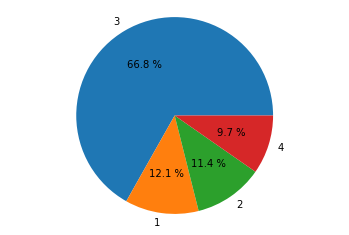

In [44]:
A = dfc2Zoom.TópicoZoom.value_counts()
indices = A.index
plt.pie(A, labels=indices, autopct="%0.1f %%")
plt.axis("equal")
plt.show()

In [45]:
impresionTopicosLimp(ldaZoom,15,20)

1  lent app factur clar aplic abrir valor solucion problem demor_carg mes encuentr solicitud ningun pued 
2  funcion si aplic minut sirv deb app muestr asesor servici fall bien fech clar pesim 
3  recarg hac consult app sald dat factur compr_paquet pued compr carg dej consum paquet ver 
4  ingres aplic mal abre error app bloque siempr detall numer clar sal dias vec pag 


In [46]:
#Guardar tabla de palabras

### Modelado de Topicos por Acción

In [47]:
len(dfc2)

6463

In [48]:
len(dfc)

20310

In [49]:
#dfc = dfSent[dfSent['Q2_NPS_GROUP']!='Promotor']
len(dfSent)

44488

In [50]:
len(dfSent[dfSent['Q2_NPS_GROUP']!='Promotor'])

20310

In [51]:
len(dfSent[dfSent['Q2_NPS_GROUP']!='Promotor'].fillna(''))

20310

In [52]:
numeroTopicos=4
topicoZoom=4

In [53]:
ZoomAccion=dfc2.copy()

In [54]:
ZoomAccion.columns

Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'Q19', 'Q2_NPS_GROUP', 'Q2',
       'Q3', 'Q4', 'Q9', 'Q10', 'Q11', 'Q12', 'Q15', 'Q26_1', 'Q22_1', 'Q18',
       'Q24_1', 'Q20', 'Nombre del cliente App', 'ID cuenta o Telefono App',
       'email App', 'Segmento App', 'Modulo App', 'Accion',
       'Q_DataPolicyViolations', 'Q15 - Parent Topics',
       'Q15 - Sentiment Polarity', 'Q15 - Sentiment Score', 'Q15 - Sentiment',
       'Q15 - Topic Sentiment Label', 'Q15 - Topic Sentiment Score',
       'Q15 - Topics', 'Q20 - Parent Topics', 'Q20 - Sentiment Polarity',
       'Q20 - Sentiment Score', 'Q20 - Sentiment',
       'Q20 - Topic Sentiment Label', 'Q20 - Topic Sentiment Score',
       'Q20 - Topics', 'Tokens_Q4',

In [55]:
acciones=ZoomAccion.Accion.unique()

Pre_Detalle_Plan


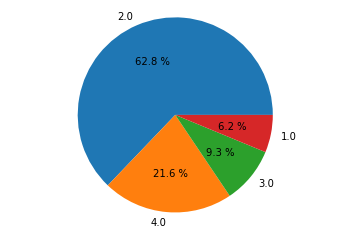

1  registr encuentr line si actualiz solucion busc telefon asesor cambi_numer facil asoci_cuent clar_vide respuest chat respond da tiemp corre se 
2  pued dej app ver plan ingres cuent clar_hog clar consult hog opcion necesit aparec dat cambi inform dic permit numer 
3  servici internet mal llam sirv lent nunc tecnic pesim cobr señal client solicit fall contest abre mes atencion tv contrat 
4  pag factur pud hac aplic funcion quier cancel entrar sal encontr equip wifi realiz sab activ mir cambi_clav sald compr 
Pre_Elegidos


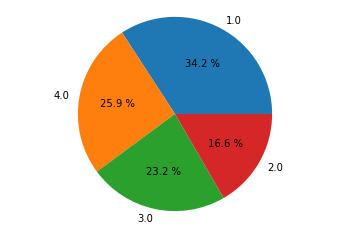

1  eleg ingres dej numer amig pued permit agreg pud registr app famili pag_factur error inscrib ver hac cambi sal pod 
2  famili_amig numer registr pag ningun hac dej realiz pued llam pud entrar activ agreg consult plan intent benefici demor line 
3  plan pag factur inform equip pued solucion cuent clar necesit cobr asesor line cambi ver clar_vide acced respuest sab hog 
4  lent servici mal señal funcion dat app internet aplic sirv pesim si actualiz fall mejor clar cae buen red carg 
Pre_Consulta_Saldos


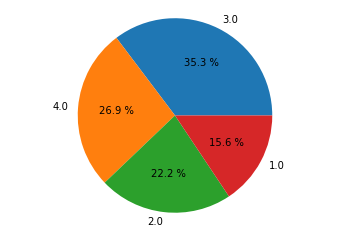

1  pag necesit oper quis solucion asesor wifi cuant dej dat deb acces ver conect cos celul habl form sac ayud 
2  servici lent hac nunc lleg mal facil cambi pas mejor equip mes señal pospag dos acab solicit pues control verd 
3  sald consum paquet ver inform dat recarg gust minut vec hac permit bien clar siempr mir error adquir real reflej 
4  app recarg pod funcion clar compr_paquet realiz deb carg cobertur demor llam dat si compr activ sirv fall sol dias 
Pre_Gestionar_Equipo


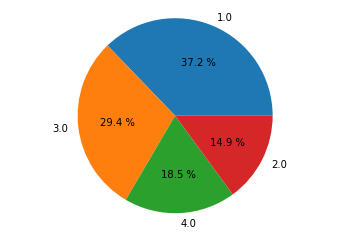

1  equip pag celul plan compr dej factur pued clar pud si nuev asesor cancel ver averigu equip_financi dat necesit inform 
2  pued si cambi consult numer clar llam hac dat permit solucion quier registr oper clav imei dar cel duplic aparec 
3  registr equip mal lent internet señal graci bien servici dic ningun buen app pesim moment pud_registr much posibl cos hog 
4  app funcion ingres nunc llam siempr hac sal fall clar servici pag_factur sirv dificil carg tiemp vec solucion contest señal 
Pre_Paquetes-Recargas


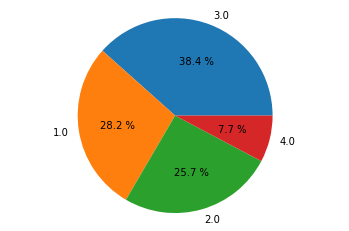

1  funcion mal lent app paquet señal compr si sald dias compr_paquet dat activ aplic dic clar siempr hac da pes 
2  compr app sirv dat pag compr_paquet tarjet pud ingres tarjet_credit nunc cae demor acept registr nombr lleg siempr pod dic 
3  recarg hac pag pued dej realiz permit pud line carg_factur hog app celul pse prepag carg cuent factur funcion paquet 
4  compr_paquet servici qued pag carg dej pas proces transaccion pse intent funcion qued_blanc error inform client internet avanz demor activ 


In [56]:
modelosAccion={}
for accion in acciones:
    print(accion)
    Lista_generalZoom=[]
    ZoomAccionAux=ZoomAccion[ZoomAccion['Accion']==accion]
    for column in Qs:   
        if column in ('Q4','Q10','Q12','Q15','Q18','Q20') :
            listAux = ZoomAccionAux["Tokens_"+column+"_T"].tolist()
            listAux = [x for x in listAux if x!= []]
            Lista_generalZoom = Lista_generalZoom+listAux

    bigramZoom = gensim.models.Phrases(Lista_generalZoom, min_count=5, threshold=10) 
    trigramZoom = gensim.models.Phrases(bigramZoom[Lista_generalZoom], threshold=10)
    bigram_modZoom = gensim.models.phrases.Phraser(bigramZoom)
    trigram_modZoom = gensim.models.phrases.Phraser(trigramZoom)
    data_words_bigramsZoom = make_bigrams(Lista_generalZoom,bigram_modZoom)
    diccionarioZoom = Dictionary(data_words_bigramsZoom)
    diccionarioZoom.filter_extremes(no_below=2, no_above = 0.9)
    corpusZoom = [diccionarioZoom.doc2bow(noticia) for noticia in data_words_bigramsZoom]

    #ldaZoomAccion = LdaModel(corpus=corpusZoom, id2word=diccionarioZoom, 
    #               num_topics=numeroTopicos, random_state=35, 
    #               chunksize=1000, iterations=200, passes=40, alpha='auto')
    modelosAccion[accion]=LdaModel(corpus=corpusZoom, id2word=diccionarioZoom, num_topics=numeroTopicos, random_state=35, 
                   chunksize=1000, iterations=200, passes=40, alpha='auto')

    modelosAccion[accion+'dis']=pyLDAvis.gensim_models.prepare(modelosAccion[accion], corpusZoom, diccionarioZoom, sort_topics=False)
    
    ##dfc2Zoom['TópicoZoom'] = ""
    sumaTopicos = [0]*(numeroTopicos+1)
    for i in ZoomAccionAux.index:
        bow_comentario = diccionarioZoom.doc2bow(ZoomAccionAux.loc[i,'Opinion'])
        distribucion_noticia = modelosAccion[accion][bow_comentario]
        dist_contrib = [topico[1] for topico in modelosAccion[accion][bow_comentario]]
        ZoomAccionAux.loc[i,'TópicoZoomAccion']=dist_contrib.index(max(dist_contrib))+1

        # sumar pertenencias a los tópicos
        for idx, val in enumerate(dist_contrib):
            sumaTopicos[idx+1]=sumaTopicos[idx+1]+dist_contrib[idx] 

    ZoomAccionAux.TópicoZoomAccion.value_counts()
    A = ZoomAccionAux.TópicoZoomAccion.value_counts()
    indices = A.index
    plt.pie(A, labels=indices, autopct="%0.1f %%")
    plt.axis("equal")
    plt.show()

    impresionTopicosLimp(modelosAccion[accion],20,20)
    
    #acumular tabla resultados
    ZoomAccion['Top_Zoom_'+accion]=ZoomAccionAux['TópicoZoomAccion']

##  Información Modelos

In [57]:
pyLDAvis.display(modelosAccion['Pre_Detalle_Plandis'])

In [58]:
pyLDAvis.display(modelosAccion['Pre_Elegidosdis'])

In [59]:
pyLDAvis.display(modelosAccion['Pre_Consulta_Saldosdis'])

In [60]:
pyLDAvis.display(modelosAccion['Pre_Gestionar_Equipodis'])

In [61]:
pyLDAvis.display(modelosAccion['Pre_Paquetes-Recargasdis'])

######  fin Zoom

####  Construcción Tabla Final 

In [62]:
ZoomAccion

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Tokens_Q15_T,Tokens_Q18_T,Tokens_Q20_T,Opinion,Tópico,Top_Zoom_Pre_Detalle_Plan,Top_Zoom_Pre_Elegidos,Top_Zoom_Pre_Consulta_Saldos,Top_Zoom_Pre_Gestionar_Equipo,Top_Zoom_Pre_Paquetes-Recargas
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173,R_x5YL4kva6EbeuWJ,,...,"[mal, señal]",[],[],"[mal, señal]",2,3.0,NaN,NaN,NaN,NaN
11,2021-05-01 01:15:49,2021-05-01 01:21:26,IP Address,186.29.191.43,100,336,True,2021-05-01 01:21:26.392,R_3ltBuR7i97QbFAM,,...,"[cambi, mes, oper, regres, nuev, sub, mil, pes...",[],[],"[me, cambi, x, mes, oper, regres, nuev, sub, m...",1,NaN,3.0,NaN,NaN,NaN
13,2021-05-01 01:31:59,2021-05-01 01:35:12,IP Address,191.156.2.216,100,193,True,2021-05-01 01:35:12.335,R_1laRSYqAGwFA04C,,...,"[demor, carg, despues, dic, sient, trabaj, ser...",[],[],"[se, demor, carg, despues, dic, sient, trabaj,...",2,NaN,NaN,2.0,NaN,NaN
27,2021-05-01 05:44:52,2021-05-01 05:46:18,IP Address,186.84.21.49,100,86,True,2021-05-01 05:46:19.079,R_dmql0Nng4tkDhYZ,,...,"[aparec, dat, line, consult]","[pid, consult, acerc, line]",[],"[no, muestr, line, no, aparec, dat, line, cons...",5,NaN,NaN,1.0,NaN,NaN
32,2021-04-30 05:58:17,2021-04-30 06:03:52,IP Address,161.10.128.88,69,335,False,2021-05-01 06:03:56.409,R_1GUoVl2DAD230XQ,,...,[jjjjj],[],[],[jjjjj],5,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44466,2021-07-31 22:13:10,2021-07-31 22:14:45,IP Address,181.51.34.89,100,94,True,2021-07-31 22:14:45.254,R_3GlYhrgQRsanGck,,...,"[dej, cambi, corre]","[cambi, corre]",[],"[no, dej, actualiz, corre, no, dej, cambi, cor...",3,2.0,NaN,NaN,NaN,NaN
44467,2021-07-30 22:11:13,2021-07-30 22:15:09,IP Address,191.144.171.70,35,235,False,2021-07-31 22:15:10.541,R_2eVEBY0Dt6Yu7Xd,,...,[],"[quis, encontr, detall, cual, plan, telefon]",[],"[quis, encontr, detall, cual, plan, telefonia.]",3,2.0,NaN,NaN,NaN,NaN
44468,2021-07-31 22:14:12,2021-07-31 22:18:01,IP Address,190.99.186.27,100,228,True,2021-07-31 22:18:01.282,R_1IE38jhgn2nnzqH,,...,[],"[sal, conexion, internet, conect, red, wifi]",[],"[sal, conexion, internet, conect, red, wifi]",1,4.0,NaN,NaN,NaN,NaN
44469,2021-07-31 22:18:06,2021-07-31 22:21:38,IP Address,191.95.165.68,100,212,True,2021-07-31 22:21:39.090,R_1DV8yAJuVRy64fi,,...,[],[],[],"[es, aplic, necesit, ten, client, clar, ,, asi...",3,NaN,NaN,NaN,1.0,NaN


In [63]:
len(df)

44488

In [64]:
len(dfSent)

44488

In [65]:
len(dfc2)

6463

In [66]:
len(dfc2Zoom)

1281

In [67]:
TablaFinal=df.copy()
for column in Qs:    
    TablaFinal["Sent_"+column]=dfSent["Sent_"+column] 
TablaFinal['Opinion']=dfc2['Opinion']
TablaFinal['Topico']=dfc2['Tópico']
TablaFinal['TópicoZoom']=dfc2Zoom['TópicoZoom']

In [68]:
###  Agregar Información
for accion in acciones:
    TablaFinal['TópicoAccion_'+accion]=ZoomAccion['Top_Zoom_'+accion]

In [69]:
TablaFinal[TablaFinal['Accion']=="Pre_Detalle_Plan"]

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Sent_Q18,Sent_Q20,Opinion,Topico,TópicoZoom,TópicoAccion_Pre_Detalle_Plan,TópicoAccion_Pre_Elegidos,TópicoAccion_Pre_Consulta_Saldos,TópicoAccion_Pre_Gestionar_Equipo,TópicoAccion_Pre_Paquetes-Recargas
7,2021-05-01 00:32:28,2021-05-01 00:35:33,IP Address,181.244.74.127,100,184,True,2021-05-01 00:35:33.715000,R_WlDgkDboPHperPH,NaN,...,,0.9998136624179559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2021-05-01 01:11:12,2021-05-01 01:13:28,IP Address,190.26.155.7,100,136,True,2021-05-01 01:13:29.173000,R_x5YL4kva6EbeuWJ,NaN,...,,,"[mal, señal]",2,NaN,3.0,NaN,NaN,NaN,NaN
17,2021-05-01 03:33:27,2021-05-01 03:34:56,IP Address,181.142.137.9,100,88,True,2021-05-01 03:34:56.361000,R_ZmK0qDDpfWbHJi9,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2021-05-01 05:21:28,2021-05-01 05:32:42,IP Address,186.87.152.172,100,673,True,2021-05-01 05:32:42.286000,R_ANKhuvqrAAMerip,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,2021-04-30 05:39:37,2021-04-30 05:39:58,IP Address,181.58.39.39,6,21,False,2021-05-01 05:40:00.089000,R_2Y2HJRaQo1gqBFg,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44458,2021-07-30 21:50:52,2021-07-30 21:51:04,IP Address,190.130.94.48,6,12,False,2021-07-31 21:51:05.852000,R_3HAdtWrDUXJdN9s,NaN,...,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44466,2021-07-31 22:13:10,2021-07-31 22:14:45,IP Address,181.51.34.89,100,94,True,2021-07-31 22:14:45.254000,R_3GlYhrgQRsanGck,NaN,...,-0.8777346409377504,,"[no, dej, actualiz, corre, no, dej, cambi, cor...",3,NaN,2.0,NaN,NaN,NaN,NaN
44467,2021-07-30 22:11:13,2021-07-30 22:15:09,IP Address,191.144.171.70,35,235,False,2021-07-31 22:15:10.541000,R_2eVEBY0Dt6Yu7Xd,NaN,...,0.27066442083004083,,"[quis, encontr, detall, cual, plan, telefonia.]",3,NaN,2.0,NaN,NaN,NaN,NaN
44468,2021-07-31 22:14:12,2021-07-31 22:18:01,IP Address,190.99.186.27,100,228,True,2021-07-31 22:18:01.282000,R_1IE38jhgn2nnzqH,NaN,...,-0.6408767781725347,,"[sal, conexion, internet, conect, red, wifi]",1,NaN,4.0,NaN,NaN,NaN,NaN


In [70]:
TablaFinal.to_csv('TablaFinalMay_Jul.csv',index=False, sep=';', encoding="utf-8-sig")